In [1]:
%matplotlib inline
import fasta_subseq_2 as fa
import seq_plotmethods as sp
import itertools as it
import tables as tb
import numpy as np
import subprocess as subp
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import re, os

from __future__ import division

2. Import data & normalize
-
- Load h5 tables holding read pileup data
- Load peak data generated by macs2
- Calculate peak overlap among datasets
- Use carrier (*D. pseudoobscura*) peaks data to normalize across samples
- Calculate FDR-based cutoffs for high-confidence anterior- and posterior-enriched peak categories
- Plot binding data for A vs. P chIP datasets

In [2]:
# Working directory; change if necessary
home = os.environ["HOME"]
current_dir = home + "/Dropbox/Documents/Manuscripts/slicing/analysis_notebook/"
genomes_dir = current_dir + "genomes/"
reads_dir = current_dir + "reads/"
data_out_dir = current_dir + "data/"
figs_dir = current_dir + "figs/"
scripts_dir = current_dir + "scripts/"
mapping_dir = data_out_dir + "mapping/"
peaks_dir = data_out_dir + "peaks/"
h5_dir = data_out_dir + "hf5/"

# Define chromosome names for dmel and dpse
DMEL_CHRS = ['2L','2R','3L','3R','X','YHet','4','2LHet','2RHet','3LHet','3RHet','XHet','U','Uextra']
DMEL_CHRS_EU = ['2L','2R','3L','3R','X']

In [3]:
class chipExpt():
    def __init__(self,group,name="NoName",chrs=DMEL_CHRS_EU,chr_ext='ext'):
        self.chr_dict = {}
        self.group = group
        self.name = name
        arrays = group._v_children.items()
        if chrs:
            for ch in chrs:
                chr_found = 0
                for (name,node) in arrays:
                    if re.search(chr_ext + "\w*_(chr)?"+ch+"$",name):
                        #print (ch,name,node.name)
                        chr_found = 1
                        self.chr_dict[ch] = node
                        break
                if chr_found == 0:
                    print "no chr found for %s" % (ch,)
        else:
            for n in group._f_walkNodes():
                ch_s = re.search("chr(.+)",n.name)
                self.chr_dict[ch_s.group(1)] = n
                break
                    
    def __getitem__(self,item):
        return self.chr_dict[item]

    def write_wig(self,chr_convert=None,span=10,outfile=None):
        if outfile == None:
            outfile = self.name + ".wig"
        wigout = open(outfile,"w")
        print >> wigout, "track type=wiggle_0 name=%s description=%s visibility=full autoScale=off maxHeightPixels=100:50:20" % (self.name,self.name)
        for (chrom,chr_arr) in self.chr_dict.items():
            print "Writing %s..." % (chrom,),
            name = chrom
            if chr_convert != None:
                name = chr_convert[chrom]
            print >> wigout, "variableStep chrom=%s span=%d" % (name,span)
            for i in np.arange(1,len(chr_arr),step=span):
                print >> wigout, "%d\t%f" % (i,np.sum(chr_arr[i:i+span])/float(span))
            print "done!"
        wigout.close()
        
def fig_simplify(axis,ticklabelfontsize=10,labelfontsize=14):
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    axis.tick_params(top='off',right='off',which='both')
    axis.set_yticklabels(axis.get_yticks(),fontsize=ticklabelfontsize)
    axis.set_xticklabels(axis.get_xticks(),fontsize=ticklabelfontsize)
    axis.set_ylabel(axis.get_ylabel(),fontsize=labelfontsize)
    axis.set_xlabel(axis.get_xlabel(),fontsize=labelfontsize)

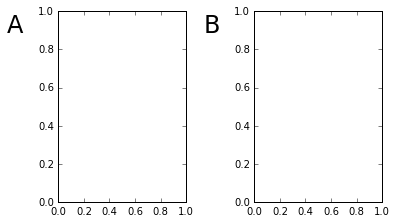

In [8]:
a = plt.gca()
f = plt.gcf()
plt.subplot(121)
plt.annotate('A',xy=(1,0),xytext=(-.4,.99),xycoords='axes fraction',textcoords='axes fraction',fontsize=24,horizontalalignment='left',verticalalignment='top')

plt.subplot(122)
plt.annotate('B',xy=(1,0),xytext=(-.4,.99),xycoords='axes fraction',textcoords='axes fraction',fontsize=24,horizontalalignment='left',verticalalignment='top')

f.tight_layout(pad=4,h_pad=4,w_pad=4)
f.set_tight_layout(None)


In [4]:
# Load treatment data

# giant ChIP
gtAm_h5 = tb.open_file(h5_dir+'gtA_dmel.h5', mode='r+')
gtPm_h5 = tb.open_file(h5_dir+'gtP_dmel.h5', mode='r+')
gtCm_h5 = tb.open_file(h5_dir+'gtC_dmel.h5', mode='r+')
gtW1m_h5 = tb.open_file(h5_dir+'gtW1_dmel.h5', mode='r+')
gtW2m_h5 = tb.open_file(h5_dir+'gtW2_dmel.h5', mode='r+')

# Load dmel input data - concatenated reads from all input samples
inAllm_h5 = tb.open_file(h5_dir+'inAll_dmel.h5', mode='r+')

# make chipExpt objects for all above (tag-normed and raw counts)
gtAm_tn = chipExpt(gtAm_h5.root.tag_counts.ext_tags,"Dmel Ant GT ChIP, tag-normalized")
gtPm_tn = chipExpt(gtPm_h5.root.tag_counts.ext_tags,"Dmel Post GT ChIP, tag-normalized")
gtCm_tn = chipExpt(gtCm_h5.root.tag_counts.ext_tags,"Dmel Combo GT ChIP, tag-normalized")
gtW1m_tn = chipExpt(gtW1m_h5.root.tag_counts.ext_tags,"Dmel Whole Rep1 GT ChIP, tag-normalized")
gtW2m_tn = chipExpt(gtW2m_h5.root.tag_counts.ext_tags,"Dmel Whole Rep2 GT ChIP, tag-normalized")


In [5]:
# Load peak data

try:
    pks_h5 = tb.open_file(peaks_dir+"/peaks.h5","w")
except ValueError:
    pks_h5.close()
    pks_h5 = tb.open_file(peaks_dir+"/peaks.h5","w")

# GT peaks    
gtAm_pks_tb = sp.read_macs(pks_h5,peaks_dir+"gtA_dmel_peaks.xls",expt_name="gtAm_pks")
gtPm_pks_tb = sp.read_macs(pks_h5,peaks_dir+"gtP_dmel_peaks.xls",expt_name="gtPm_pks")
gtCm_pks_tb = sp.read_macs(pks_h5,peaks_dir+"gtC_dmel_peaks.xls",expt_name="gtCm_pks")
gtW1m_pks_tb = sp.read_macs(pks_h5,peaks_dir+"gtW1_dmel_peaks.xls",expt_name="gtW1m_pks")
gtW2m_pks_tb = sp.read_macs(pks_h5,peaks_dir+"gtW2_dmel_peaks.xls",expt_name="gtW2m_pks")

gtAm_pks = [x for x in sp.pks_to_dict(gtAm_pks_tb) if x['chr'] in DMEL_CHRS_EU]
gtPm_pks = [x for x in sp.pks_to_dict(gtPm_pks_tb) if x['chr'] in DMEL_CHRS_EU]
gtCm_pks = [x for x in sp.pks_to_dict(gtCm_pks_tb) if x['chr'] in DMEL_CHRS_EU]
gtW1m_pks = [x for x in sp.pks_to_dict(gtW1m_pks_tb) if x['chr'] in DMEL_CHRS_EU]
gtW2m_pks = [x for x in sp.pks_to_dict(gtW2m_pks_tb) if x['chr'] in DMEL_CHRS_EU]

In [6]:
# get union sets

# GT
(gtm_un0_pks,gtm_in0_pks,gtm_OL0_pks) = sp.peak_union(0,0,['gtAm','gtPm','gtCm','gtW1m','gtW2m'],True,gtAm_pks,gtPm_pks,gtCm_pks,gtW1m_pks,gtW2m_pks)
gtm_5wy_OLs = [x for x in gtm_in0_pks if len(set(x['sets'])) == 5]
print "GT Dmel Final 5-way overlaps: %d" % (len(gtm_5wy_OLs))

# Get matching peak sets from each GT dataset
(top1000gtW1m_5wy_OL_pi,top1000gtW1m_5wy_OL) = zip(*sp.get_top_n_peaks(1000,gtm_5wy_OLs,gtW1m_tn))
gtAm_top1000gtW1m_5OL_tn = sp.make_array_from_peaks('ns',top1000gtW1m_5wy_OL,gtAm_tn)
gtPm_top1000gtW1m_5OL_tn = sp.make_array_from_peaks('ns',top1000gtW1m_5wy_OL,gtPm_tn)
gtW1m_top1000gtW1m_5OL_tn = sp.make_array_from_peaks('ns',top1000gtW1m_5wy_OL,gtW1m_tn)
gtW2m_top1000gtW1m_5OL_tn = sp.make_array_from_peaks('ns',top1000gtW1m_5wy_OL,gtW2m_tn)
gtCm_top1000gtW1m_5OL_tn = sp.make_array_from_peaks('ns',top1000gtW1m_5wy_OL,gtCm_tn)

# Get 5-way union peak sets from each GT experiment
gtAm_5un_tn = sp.make_array_from_peaks('ns',gtm_un0_pks,gtAm_tn)
gtPm_5un_tn = sp.make_array_from_peaks('ns',gtm_un0_pks,gtPm_tn)
gtW1m_5un_tn = sp.make_array_from_peaks('ns',gtm_un0_pks,gtW1m_tn)
gtW2m_5un_tn = sp.make_array_from_peaks('ns',gtm_un0_pks,gtW2m_tn)
gtCm_5un_tn = sp.make_array_from_peaks('ns',gtm_un0_pks,gtCm_tn)

Peak window (peak width +/- 0)
Starting Sets:
	gtAm :     3000 peaks
	gtPm :      915 peaks
	gtCm :     1870 peaks
	gtW1m :     1629 peaks
	gtW2m :     1557 peaks
8971 total peaks in starting set
3333 in union, 2022 in intersect
final isct: 2022 before filtering, 2022 after
total overlapping peaks (all sets): 4044
By-Experiment Overlap Counts:
	gtPm :      165
	gtCm :     1054
	gtW2m :      380
	gtW1m :      745
	gtAm :     1700
GT Dmel Final 5-way overlaps: 634


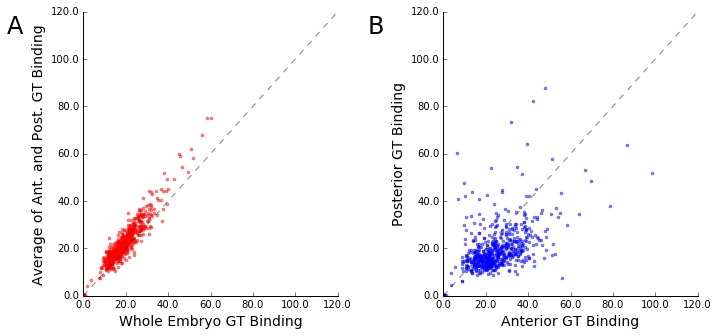

In [7]:
gt_tns = [gtAm_top1000gtW1m_5OL_tn,gtPm_top1000gtW1m_5OL_tn,gtW1m_top1000gtW1m_5OL_tn,gtW2m_top1000gtW1m_5OL_tn,gtCm_top1000gtW1m_5OL_tn]
# gt scatter plots - 1000pk intersection across all 5 expts
xy = np.arange(300)
plt.gcf().set_figheight(5)
plt.gcf().set_figwidth(10)
ax1 = plt.subplot(121)
gt_avg = (gtAm_top1000gtW1m_5OL_tn + gtPm_top1000gtW1m_5OL_tn) / 2
plt.xlim(0,120)
plt.ylim(0,120)
plt.xlabel("Whole Embryo GT Binding",fontsize=14)
plt.ylabel("Average of Ant. and Post. GT Binding",fontsize=14)
plt.plot(gtW1m_top1000gtW1m_5OL_tn,gt_avg,"r.",alpha=0.5)
plt.plot(xy,xy,'k--',alpha=0.5)[0]
fig_simplify(ax1)
plt.annotate('A',xy=(1,0),xytext=(-.3,.99),xycoords='axes fraction',textcoords='axes fraction',fontsize=24,horizontalalignment='left',verticalalignment='top')
ax2 = plt.subplot(122)
plt.xlim(0,120)
plt.ylim(0,120)
plt.plot(gtAm_top1000gtW1m_5OL_tn,gtPm_top1000gtW1m_5OL_tn,"b.",alpha=0.5)
plt.plot(xy,xy,'k--',alpha=0.5)
plt.xlabel("Anterior GT Binding",fontsize=14)
plt.ylabel("Posterior GT Binding",fontsize=14)
fig_simplify(ax2)
plt.annotate('B',xy=(1,0),xytext=(-.3,.99),xycoords='axes fraction',textcoords='axes fraction',fontsize=24,horizontalalignment='left',verticalalignment='top')

plt.gcf().tight_layout(pad=2,h_pad=4,w_pad=4)
plt.gcf().set_tight_layout(None)

plt.savefig(figs_dir + "/Fig1_AB.pdf",format='pdf')

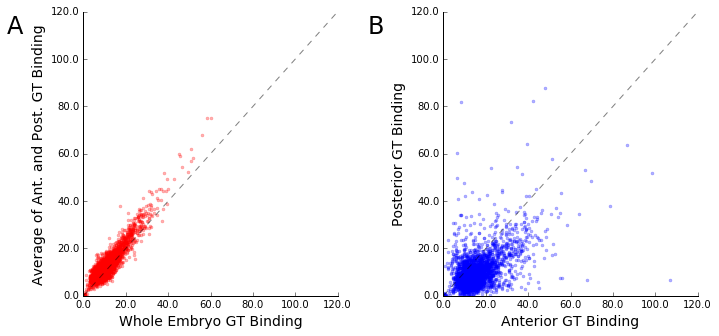

In [8]:
# gt scatter plots - union of peaks across all 5 expts
xy = np.arange(300)
plt.gcf().set_figheight(5)
plt.gcf().set_figwidth(10)
ax1 = plt.subplot(121)
gt_avg = (gtAm_5un_tn + gtPm_5un_tn) / 2
plt.xlim(0,120)
plt.ylim(0,120)
plt.xlabel("Whole Embryo GT Binding",fontsize=14)
plt.ylabel("Average of Ant. and Post. GT Binding",fontsize=14)
plt.plot(gtW1m_5un_tn,gt_avg,"r.",alpha=0.3)
plt.plot(xy,xy,'k--',alpha=0.5)
fig_simplify(ax1)
plt.annotate('A',xy=(1,0),xytext=(-.3,.99),xycoords='axes fraction',textcoords='axes fraction',fontsize=24,horizontalalignment='left',verticalalignment='top')
ax2 = plt.subplot(122)
plt.xlim(0,120)
plt.ylim(0,120)
plt.plot(gtAm_5un_tn,gtPm_5un_tn,"b.",alpha=0.3)
plt.plot(xy,xy,'k--',alpha=0.5)
plt.xlabel("Anterior GT Binding",fontsize=14)
plt.ylabel("Posterior GT Binding",fontsize=14)
fig_simplify(ax2)
plt.annotate('B',xy=(1,0),xytext=(-.3,.99),xycoords='axes fraction',textcoords='axes fraction',fontsize=24,horizontalalignment='left',verticalalignment='top')

plt.gcf().tight_layout(pad=2,h_pad=4,w_pad=4)
plt.gcf().set_tight_layout(None)


plt.savefig(figs_dir + "/Fig1_AB.pdf",format='pdf')


In [9]:
def replace_nw(match):
    return "\\" + match.group(1)

def stacked_plots_w_highlight_pk(peak_dict,pad,h_regions,gff,sum_fn,sum_tracks,add_sum_to_tracks,sum_label,norm_expt,*expts):
    pk_chr = peak_dict['chr']
    pk_start = peak_dict['start'] - pad
    pk_end = peak_dict['end'] + pad
    stacked_plots_w_highlight(pk_chr,pk_start,pk_end,h_regions,gff,sum_fn,sum_tracks,add_sum_to_tracks,sum_label,norm_expt,*expts)

def stacked_plots_w_highlight(chr,start,end,h_regions,gff,sum_fn,sum_tracks,add_sum_to_tracks,sum_label,norm_expt,legend,*expts):
    style=sp.get_line_style()
    ymax = 1.0
    if len(norm_expt) < len(expts): 
        ymax = max([(max(ex[chr][start:end])*1.2) for (n,ex) in enumerate(expts) if n not in norm_expt])
    ylimits = (0,ymax)
    
    
    genes = gff.get_region_annot(chr,start,end,"gene")['gene']
    
    print ymax
    
    for (i,x) in enumerate(expts):
        #shape = int(str(len(expts)) + "1" + str(i + 1))
        plt.subplot(len(expts),1,i+1)
        plotted_genes = []
        text_coords = np.linspace(ymax,0,num=len(h_regions)+2)[1:-1]
        
        if i in norm_expt:
            #ylim(0,1.2)
            sp.plot_genome_region(chr,start,end,style,x)
        else:
            plt.ylim(ylimits)
            sp.plot_genome_region(chr,start,end,style,x)
            
        if i in add_sum_to_tracks:
            print sum_fn([y[chr][start:end] for (i,y) in enumerate(expts) if i in sum_tracks])
            plt.plot(np.arange(start,end),sum_fn([y[chr][start:end] for (i,y) in enumerate(expts) if i in sum_tracks]),"k--",alpha=0.7,linewidth=3,label=sum_label)
            if legend:
                plt.legend()
            #plt.xlim(start,end)
        
        for (s,h) in zip(text_coords,h_regions):
            plt.axvspan(h['start'], h['end'], facecolor='k', alpha=0.2)
            h_region_name = ""
            try:
                h_region_name = re.sub("((\W|_))",replace_nw,h['name'])
            except KeyError:
                h_region_name = "%s:%d-%d" % (h['chr'],h['start'],h['end'])
            print h_region_name
            ann_xy = ((h['start'] + h['end'])/2,plt.ylim()[1]/2) 
            text_xy = (h['start'],s)
            plt.annotate(h_region_name,xy=ann_xy,xytext=text_xy) 

        for g in genes:
            pad = 0
            g['chr'] = '-'
            for gn in plotted_genes:
                if sp.overlap(g,gn) != (0,0):
                    pad = gn['pad'] + .11
            plt.axvspan(g['start'], g['end'], ymin=0.025+pad,ymax=0.125+pad,facecolor='g', alpha=0.2)
            annot_coords = ((g['start'] + g['end'])/2.0,(0.075+pad)*ymax)
            gene_name_direction = g['name'] + r'$\quad \longrightarrow$'
            if g['strand'] == '-':
                gene_name_direction = '$\longleftarrow \quad$' + g['name']
            plt.annotate(gene_name_direction,xy=annot_coords,xytext=(0,20),textcoords='offset points',
                     arrowprops=None, ha='center', va='center')
            g['pad'] = pad
            plotted_genes.append(g)
            print plotted_genes
        ax = plt.gca()
        fig_simplify(ax,labelfontsize=12)
            
def ax1_mean(expts):
    expt_ar = np.vstack(expts)
    return np.mean(expt_ar,axis=0)

def two_exp_diff(expts):
    return expts[0] - expts[1]


In [10]:
gff_h5 = h5_dir + "/gff.h5"
gff_dmel = sp.GFFtable(genomes_dir + "dmel-all-no-analysis-r5.17.genes.gff",gff_h5,DMEL_CHRS_EU,"gene")

('gene',)
h
8668859
[('h', 8668859L)]
99.3893243009
(<__main__.chipExpt instance at 0x1147b2368>,)
[{'end': 8672339L, 'name': 'h', 'Parent': '', 'FBid': 'FBgn0001168', 'start': 8668859L, 'chr': '-', 'pad': 0, 'strand': '+'}]
(<__main__.chipExpt instance at 0x1147cf6c8>,)
[{'end': 8672339L, 'name': 'h', 'Parent': '', 'FBid': 'FBgn0001168', 'start': 8668859L, 'chr': '-', 'pad': 0, 'strand': '+'}]
(<__main__.chipExpt instance at 0x1147e6b90>,)
[ 4.06587398  4.06587398  4.06587398 ...,  1.95081983  1.95081983
  1.95081983]
[{'end': 8672339L, 'name': 'h', 'Parent': '', 'FBid': 'FBgn0001168', 'start': 8668859L, 'chr': '-', 'pad': 0, 'strand': '+'}]


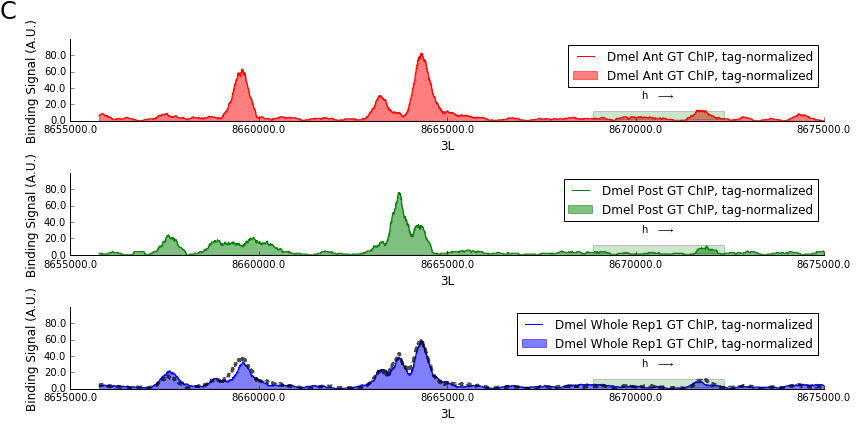

In [11]:
# hairy
plt.gcf().set_figwidth(12)
plt.gcf().set_figheight(6)
stacked_plots_w_highlight("3L",8655759,8675000, [], gff_dmel, ax1_mean, [0,1], [2,], 'Mean of Anterior and Posterior GT', [], False, gtAm_tn, gtPm_tn, gtW1m_tn,)
plt.annotate('C',xy=(1,0),xytext=(0,1),xycoords='figure fraction',textcoords='figure fraction',fontsize=24,horizontalalignment='left',verticalalignment='top')

plt.gcf().tight_layout(pad=2,h_pad=1,w_pad=3)
plt.gcf().set_tight_layout(None)

plt.savefig(figs_dir + "/Fig1_C.pdf",format='pdf')

### A-P Difference FDR Calculations

In [12]:
def diff_log2(ctl1,ctl2,exp1,exp2):
    ctl_diff = np.array([x for x in np.log2((ctl1 / ctl2)) if np.isfinite(x)])
    exp_diff = np.array([x for x in np.log2((exp1 / exp2)) if np.isfinite(x)])
    return (ctl_diff,exp_diff)

def diff_AminusP(ctl1,ctl2,exp1,exp2):
    ctl_diff = np.array(ctl1-ctl2)
    exp_diff = np.array(exp1-exp2)
    return (ctl_diff,exp_diff)

def diff_chip_fdr(ctl_r1,ctl_r2,exp1,exp2,peaks,fdr,verbose=False,diff_metric_fn=diff_log2,plot=True):
    ctl_diff,exp_diff = diff_metric_fn(ctl_r1,ctl_r2,exp1,exp2)
    ctl_diff = (ctl_diff - ctl_diff.mean())
    exp_diff = (exp_diff - exp_diff.mean())
    
    null_fit_norm_params = stats.norm.fit(ctl_diff) 
    
    exp_l_pvals = stats.norm.cdf(exp_diff,*null_fit_norm_params)
    exp_r_pvals = stats.norm.sf(exp_diff,*null_fit_norm_params)
    exp_raw_pvals = [min(x,y) for (x,y) in zip(exp_l_pvals,exp_r_pvals)]
    
    exp_pvals = sorted(zip(exp_diff,exp_raw_pvals,peaks),cmp=(lambda x,y: cmp(x[1],y[1])))

    fdr_norm_peaks = [x for (i,x) in enumerate(exp_pvals) if x[1] <= ((i+1)/len(exp_pvals))*(fdr/2)]
    fdr_norm_cutoff = abs(fdr_norm_peaks[-1][0])
    if plot:
        (n,bins,dummy2) = plt.hist(exp_diff,bins=100,normed=True,alpha=0.5)
        plt.vlines([fdr_norm_cutoff,-fdr_norm_cutoff],0,n.max(),linewidth=3,linestyle="--")
        plt.xlabel('Ant GT - Post GT')
        plt.ylabel('Fraction of Peaks')
        fig_simplify(plt.gca())
    return fdr_norm_cutoff, fdr_norm_peaks

def plot_fdr(pks1,pks2,pks1_name,pks2_name,fdr,fdr_cut,bins=80,diff_statistic='subtract',mean_norm=0.0):
    diff = 0.0
    if diff_statistic == 'subtract':
        # FDR statistic is peak-wise binding difference 
        diff = pks1 - pks2
    elif diff_statistic == 'log2_ratio':
        # FDR statistic is log2-transformed peak-wise ratio
        diff = np.array([x for x in np.log2((pks1 / pks2)) if ((not np.isinf(x)) and (not np.isnan(x)))])
    
    mean_shift = np.mean(diff) - mean_norm
    diff = diff - mean_shift
    
    plt.xlim(-np.max(np.array([np.min(bins),np.max(bins)])),np.max(np.array([np.min(bins),np.max(bins)])))
    plt.xlabel("$\longleftarrow$ %s \qquad %s $\longrightarrow$" % (pks2_name, pks1_name))
    plt.axvline(x=fdr_cut, linestyle='--',linewidth=2,color='k',label=r'$%d\%%$ FDR = %2f' % (int(fdr * 100),fdr_cut),alpha=0.5)
    plt.axvline(x=-fdr_cut, linestyle='--',linewidth=2,color='k',alpha=0.5)
    hbins = plt.hist(diff,bins=bins)
    plt.legend()

599
328
271
3333
2734


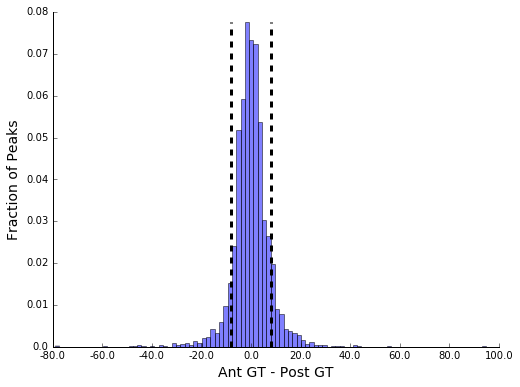

In [13]:
plt.gcf().set_figwidth(8)
plt.gcf().set_figheight(6)
gt_5unfdr1_subtr_cut, gt_5unfdr1_subtr_cp = diff_chip_fdr(gtW1m_5un_tn,gtW2m_5un_tn,gtAm_5un_tn,gtPm_5un_tn,gtm_un0_pks,0.01,diff_metric_fn=diff_AminusP)
gtA_subtr_fdr1 = [x for x in gt_5unfdr1_subtr_cp if x[0] > 0]
gtP_subtr_fdr1 = [x for x in gt_5unfdr1_subtr_cp if x[0] < 0]
gtA_subtr_fdr1_pk = zip(*gtA_subtr_fdr1)[2]
gtP_subtr_fdr1_pk = zip(*gtP_subtr_fdr1)[2]
gtND_fdr1 = [x for x in gtm_un0_pks if (x not in gtA_subtr_fdr1_pk) and (x not in gtP_subtr_fdr1_pk)]
print len(gt_5unfdr1_subtr_cp)
print len(gtA_subtr_fdr1)
print len(gtP_subtr_fdr1)
print len(gtm_un0_pks)
print len(gtND_fdr1)
plt.savefig(figs_dir + "FigS1_A_FDR1.pdf",format='pdf')

867
470
397
3333
2466


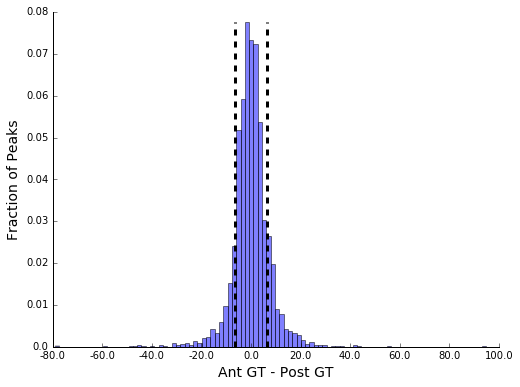

In [14]:
plt.gcf().set_figwidth(8)
plt.gcf().set_figheight(6)
gt_5unfdr5_subtr_cut,gt_5unfdr5_subtr_cp = diff_chip_fdr(gtW1m_5un_tn,gtW2m_5un_tn,gtAm_5un_tn,gtPm_5un_tn,gtm_un0_pks,0.05,diff_metric_fn=diff_AminusP)
gtA_subtr_fdr5 = [x for x in gt_5unfdr5_subtr_cp if x[0] > 0]
gtP_subtr_fdr5 = [x for x in gt_5unfdr5_subtr_cp if x[0] < 0]
gtA_subtr_fdr5_pk = zip(*gtA_subtr_fdr5)[2]
gtP_subtr_fdr5_pk = zip(*gtP_subtr_fdr5)[2]
gtND_fdr5 = [x for x in gtm_un0_pks if (x not in gtA_subtr_fdr5_pk) and (x not in gtP_subtr_fdr5_pk)]
print len(gt_5unfdr5_subtr_cp)
print len(gtA_subtr_fdr5)
print len(gtP_subtr_fdr5)
print len(gtm_un0_pks)
print len(gtND_fdr5)
plt.savefig(figs_dir + "FigS1_B_FDR5.pdf",format='pdf')

In [15]:
# [TABLE OF FDR RESULTS]

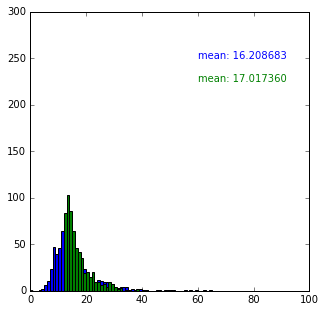

In [16]:
# Make sure 
avg_all_whole = np.mean(np.array([gtW1m_5un_tn,gtW2m_5un_tn,gtCm_5un_tn]),axis=0)
fdr1_cp_pkbind = [x for x in zip(gtAm_5un_tn,gtPm_5un_tn,gtW1m_5un_tn,gtW2m_5un_tn,gtCm_5un_tn,avg_all_whole,gtm_un0_pks) if (x[6] in gtA_subtr_fdr1_pk) or (x[6] in gtP_subtr_fdr1_pk)]
fdr1_notcp_pkbind = [x for x in zip(gtAm_5un_tn,gtPm_5un_tn,gtW1m_5un_tn,gtW2m_5un_tn,gtCm_5un_tn,avg_all_whole,gtm_un0_pks) if not ((x[6] in gtA_subtr_fdr1_pk) or (x[6] in gtP_subtr_fdr1_pk))]
plt.gcf().set_figheight(5)
plt.gcf().set_figwidth(5)

fdr1_notcp_highpkbind = sorted(fdr1_notcp_pkbind,cmp=(lambda x,y: cmp(y[5],x[5])))[:len(fdr1_cp_pkbind)] 
plt.hist([x[5] for x in fdr1_cp_pkbind],bins=100,range=(0,100))
plt.xlim(0,100)
plt.ylim(0,300)
plt.text(60,250,"mean: %4f" % (np.mean([x[5] for x in fdr1_cp_pkbind]),),color='blue')
plt.hist([x[5] for x in fdr1_notcp_highpkbind],bins=100,range=(0,100))
plt.text(60,225,"mean: %4f" % (np.mean([x[5] for x in fdr1_notcp_highpkbind]),),color='green')

3333
3333
1% FDR cut= +/- 7.966461
5% FDR cut= +/- 6.339748


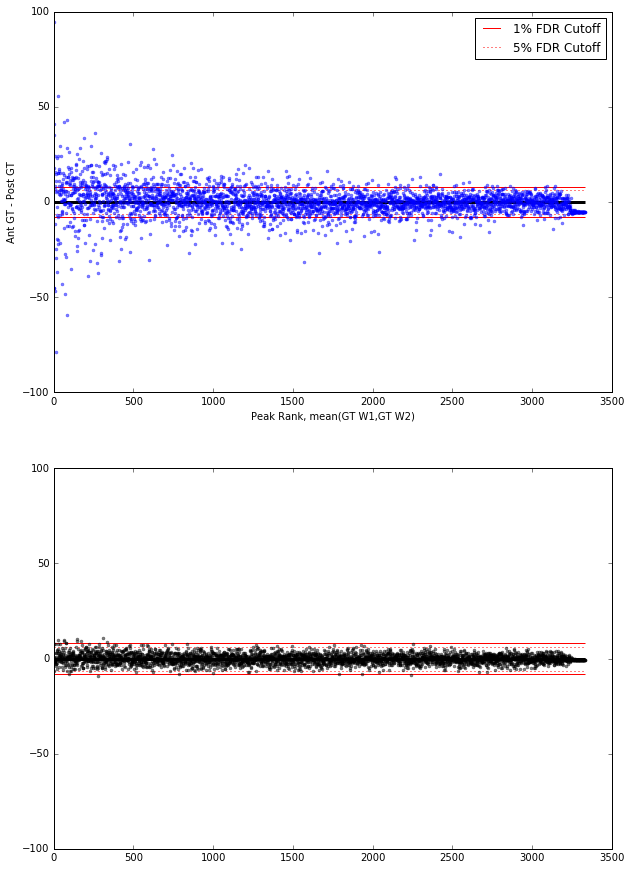

In [18]:
# Sort Whole Embryo binding for 5un peaks

w1w2_mean_5un = (gtW1m_5un_tn + gtW2m_5un_tn) / 2
#AP_log2ratio_5un = np.log2(gtAm_5un_tn / gtPm_5un_tn) - np.mean([x for x in np.log2(gtAm_5un_tn / gtPm_5un_tn) if np.isfinite(x)])
#w1w2_log2ratio_5un = np.log2(gtW1m_5un_tn / gtW2m_5un_tn)  - np.mean([x for x in np.log2(gtW1m_5un_tn / gtW2m_5un_tn) if np.isfinite(x)])
AP_diff_5un = (gtAm_5un_tn - gtPm_5un_tn) - np.mean((gtAm_5un_tn - gtPm_5un_tn))
w1w2_diff_5un = gtW1m_5un_tn - gtW2m_5un_tn - np.mean((gtW1m_5un_tn - gtW2m_5un_tn))
w1w2_mean_5un_pkdata = sorted(zip(w1w2_mean_5un,w1w2_diff_5un,AP_diff_5un,gtm_un0_pks),cmp=(lambda x,y: cmp(x[0],y[0])))
w1w2_mean_5un_srt = w1w2_mean_5un_pkdata[::-1]
print len(zip(*w1w2_mean_5un_srt)[1])
print len(w1w2_mean_5un_srt)
print "1%% FDR cut= +/- %f" % (gt_5unfdr1_subtr_cut,)
print "5%% FDR cut= +/- %f" % (gt_5unfdr5_subtr_cut,)
plt.gcf().set_figwidth(10)
plt.gcf().set_figheight(15)
plt.subplot(211)
plt.ylim(-100,100)
plt.hlines(0.0,0,len(w1w2_mean_5un_srt),linestyle="-",linewidth=3)
plt.hlines([gt_5unfdr1_subtr_cut,-gt_5unfdr1_subtr_cut],0, len(w1w2_mean_5un_srt),linestyle="-",linewidth=1,color='red',label='1% FDR Cutoff')
plt.hlines([gt_5unfdr5_subtr_cut,-gt_5unfdr5_subtr_cut],0, len(w1w2_mean_5un_srt),linestyle=":",linewidth=1,color='red',label='5% FDR Cutoff')
plt.plot(np.arange(len(w1w2_mean_5un_srt)),zip(*w1w2_mean_5un_srt)[2],'b.',alpha=0.5)
plt.xlabel("Peak Rank, mean(GT W1,GT W2)")
plt.ylabel("Ant GT - Post GT")
plt.legend()
plt.subplot(212)
plt.ylim(-100,100)
plt.plot(np.arange(len(w1w2_mean_5un_srt)),zip(*w1w2_mean_5un_srt)[1],'k.',alpha=0.5)
plt.hlines(0.0,0,len(w1w2_mean_5un_srt),linestyle="-",linewidth=3)
plt.hlines([gt_5unfdr1_subtr_cut,-gt_5unfdr1_subtr_cut],0, len(w1w2_mean_5un_srt),linestyle="-",linewidth=1,color='red',label='1% FDR Cutoff')
plt.hlines([gt_5unfdr5_subtr_cut,-gt_5unfdr5_subtr_cut],0, len(w1w2_mean_5un_srt),linestyle=":",linewidth=1,color='red',label='5% FDR Cutoff')


In [ ]:
def fdr_pks_tsv_out(pks,outfile):
    out = open(outfile,"w+")
    header = "CHR\tSTART\tEND\tSUMMIT\tLENGTH\tAP_NORM_DIFF\tAP_DIFF_PVAL\tA_BIND\tP_BIND\tW1_BIND\tW2_BIND\tCM_BIND"
    print >> out, header
    for p in pks:
        print >> out, "%s\t%d\t%d\t%d\t%d\t%f\t%f\t%f\t%f\t%f\t%f\t%f" % (p[8]['chr'],\
                                                          p[8]['start'],\
                                                          p[8]['end'],\
                                                          p[8]['summit'],\
                                                          p[8]['length'],\
                                                          p[0],\
                                                          p[1],\
                                                          p[2],\
                                                          p[3],\
                                                          p[4],\
                                                          p[5],\
                                                          p[6])
    out.close()
    
def join_pks_diff(pks,pk_bind):
    new_pks = []
    for p1 in pks:
        for p2 in pk_bind:
            if p1[2] == p2[6]:
                newpk = p1[:2] + p2
                new_pks.append(newpk)
    return new_pks

gtA_pkbind = join_pks_diff(gtA_subtr_fdr1,fdr1_cp_pkbind)
gtP_pkbind = join_pks_diff(gtP_subtr_fdr1,fdr1_cp_pkbind)
fdr_pks_tsv_out(gtA_pkbind,data_out_dir + '/supp_data/gtA_fdr1_pkbind.tsv')
fdr_pks_tsv_out(gtP_pkbind,data_out_dir + '/supp_data/gtP_fdr1_pkbind.tsv')
fdr1_notcp_highpkbind_ext = [(0.0,0.0) + x for x in fdr1_notcp_highpkbind]
print fdr1_notcp_highpkbind_ext
fdr_pks_tsv_out(fdr1_notcp_highpkbind_ext,data_out_dir + '/supp_data/gtALL_fdr1_notcp_highpkbind.tsv')